In [1]:
import os
import sys

# Add the project's root directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import random

import numpy as np
import torch

from GP_comp.GP import generate_grids
from SGLD_v7 import SgldBayesianRegression as V7
from models.stgp_neural_network import STGPNeuralNetwork
from simulate_single_modality import simulate_data
from utils import generate_linear_data, plot_mse, plot_sigma_squared, calculate_p_hat, plot_image

# Set random seed for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)


Simulated 2000 images of 100×100 = 10000 pixels true_sigma2=0.0


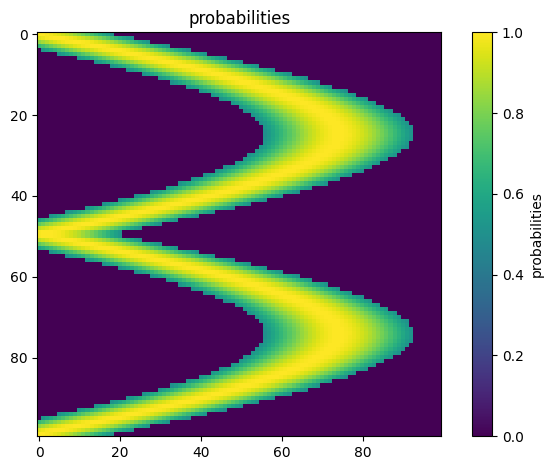

In [2]:
from simulate_single_modality import simulate_data
from utils import generate_linear_data, plot_mse, plot_sigma_squared, calculate_p_hat, plot_image, plot_r2
from torch.utils.data import Dataset, DataLoader
import torch
from torch.utils.data import Dataset
# Step 2: Generate synthetic data
# simulate a batch of images
in_feature = 100
r2 = 1.0                  # signal-to-noise ratio
n = 2000                  # number of images/samples
grids, true_beta, img, Y, true_sigma2 = simulate_data(n=n, r2=r2, dim=in_feature, random_seed=42)
# torch tensors

# pick one of your simulated images
print(f"Simulated {n} images of {in_feature}×{in_feature} = {img.shape[1]} pixels true_sigma2={true_sigma2}")
plot_image(true_beta)

X = torch.from_numpy(img).float().to('cpu')    # X.shape= (number of rows, total number of vexels)
y = torch.from_numpy(Y).float().to('cpu')      # y.shape= (number of rows,)

class mydata(Dataset):
    def __init__(self, x_list, y_list):
        self.x_list = x_list
        self.y_list = y_list
    def __len__(self):
        return len(self.y_list)
    def __getitem__(self, i):
        x = self.x_list[i].reshape(-1)
        y = self.y_list[i].detach().clone()
        return x, y

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset

def create_dataloaders(X, y, val_ratio=0.2, batch_size=32, shuffle=True):
    """
    Splits X, y into training and validation DataLoaders.
    
    Args:
        X (torch.Tensor): Feature tensor, shape (n_samples, n_features).
        y (torch.Tensor): Target tensor, shape (n_samples,).
        val_ratio (float): Proportion of dataset to use for validation (default=0.2).
        batch_size (int): Batch size for DataLoader (default=32).
        shuffle (bool): Whether to shuffle the dataset before splitting (default=True).
    
    Returns:
        train_loader (DataLoader), val_loader (DataLoader)
    """
    # Wrap tensors into a TensorDataset
    dataset = mydata(X, y)
    
    # Calculate sizes
    n_samples = len(dataset)
    n_val = int(n_samples * val_ratio)
    n_train = n_samples - n_val
    
    # Random split
    train_dataset, val_dataset = random_split(dataset, [n_train, n_val])
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, n_train, n_val
train_loader, test_loader, n_train, n_test = create_dataloaders(X, y, val_ratio=0.2, batch_size=64)

In [4]:
# Step 4: Build model
model = STGPNeuralNetwork(
    in_feature=in_feature,
    grids=grids,
    fully_connected_layers =[8, 1],
    nu_tilde=2.5,
    b_for_eigen=20.0
)

In [5]:
# Step 5: Train with SGLD
trainer = V7(
    step_size=1e-6,
    num_epochs=600,  # fix this back to 300 later
    burn_in_epochs=0,
    batch_size=64,
    model=model
)

In [6]:
trainer.train_and_eval(train_loader, test_loader)

1600
Epoch 1/600
time elapsed 0.0 seconds
Epoch 101/600
time elapsed 33.04831886291504 seconds
Epoch 201/600
time elapsed 68.46742224693298 seconds
Epoch 301/600
time elapsed 101.72013521194458 seconds
Epoch 401/600
time elapsed 134.70815229415894 seconds
Epoch 501/600
time elapsed 167.85248851776123 seconds


In [7]:
#plot_sigma_squared(trainer)

In [8]:
#plot_mse(trainer.samples['train_mse'])

In [9]:
# idx = 2
# inputs = X[idx : idx+1]       # shape [1, V]
# expected_y = Y[idx]
# print(f"Y(predicted)={trainer.predict(inputs, -1000, -1)} Y(expected)={expected_y}")

In [13]:
from utils import plot_r2

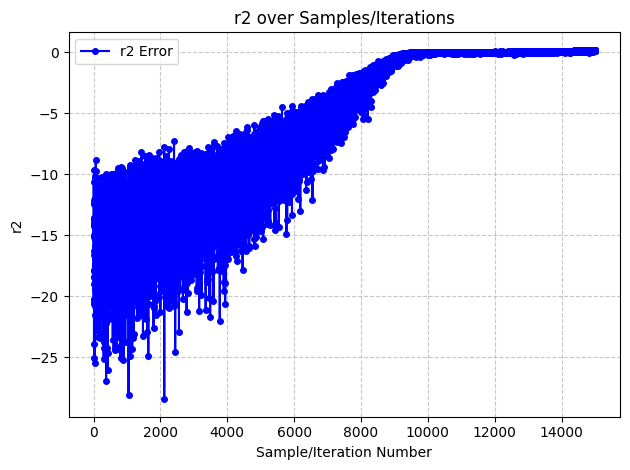

In [21]:
plot_r2(trainer.samples['train_r2'])

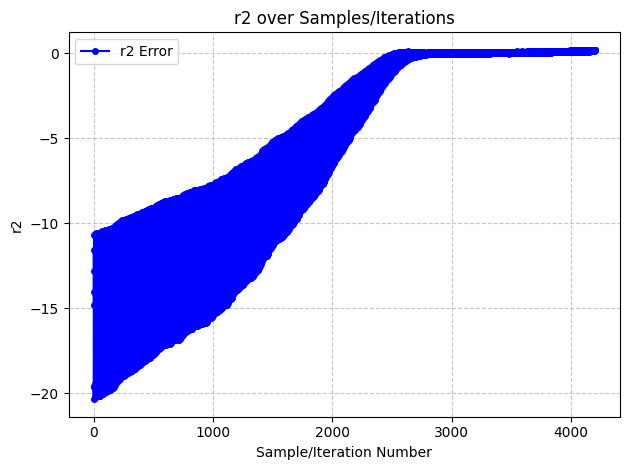

In [15]:
plot_r2(trainer.samples['eval_r2'])

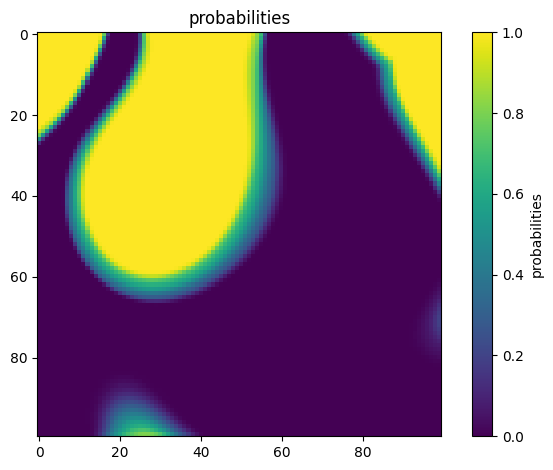

In [19]:
beta_samples = trainer.samples['beta'][-2000: -1]
p_hat = calculate_p_hat(beta_samples)
plot_image(p_hat)